#### Simulation Based Inference of the decay $B \to K^* \mu \mu$ with respect to the Wilson coefficient $C_9$
The observables of interest are $s = q^2$, $\theta_l$, $\theta_d$ and $\phi$.  

Notation in this notebook:  
Everything (parameters and data) is normalized except the objects labeled as "raw".  

### Part A: Useful objects

In [10]:
# imports
import torch
import eos
import sbi
import random
import numpy as np
import matplotlib.pyplot as plt

from sbi.utils import BoxUniform
from sbi.inference import NPE
from sbi.analysis import pairplot
from sbi.analysis import plot_summary
from sbi.diagnostics import run_sbc
from sbi.analysis.plot import sbc_rank_plot

In [11]:
# Simulator
class Simulator:
    # the simulator deals with un-normalized data (raw)
    def __init__(self, device, stride, pre_N, preruns, sbi_C9):
        self.device = device
        self.stride = stride
        self.pre_N = pre_N
        self.preruns = preruns
        self.rng = sbi_C9.rng
        self.point_dim = sbi_C9.point_dim
        self.parameter_dim = sbi_C9.parameter_dim

        self.eos_kinematics = eos.Kinematics({
            's':             2.0,   's_min':             1,       's_max' :            8.0,
            'cos(theta_l)^LHCb':  0.0,  'cos(theta_l)^LHCb_min': -1.0,      'cos(theta_l)^LHCb_max': +1.0,
            'cos(theta_k)^LHCb':  0.0,  'cos(theta_k)^LHCb_min': -1.0,      'cos(theta_k)^LHCb_max': +1.0,
            'phi^LHCb':           0.3,  'phi^LHCb_min':           -1.0*np.pi,      'phi^LHCb_max':           1.0 * np.pi,
        })

        self.eos_options = eos.Options({
            'l': 'mu',
            'q': 'd',
            'model': 'WET',
            'debug': 'false',
            'logging': 'quiet',
            'log-level': 'off',
            
        })

        self.eos_parameters = eos.Parameters()
        
        self.distribution = eos.SignalPDF.make(
            'B->K^*ll::d^4Gamma@LowRecoil',
            self.eos_parameters, # arbitrary value
            self.eos_kinematics,
            self.eos_options
        )

    def to_tensor(self, x, dtype=torch.float32):
        return torch.as_tensor(x, dtype=dtype, device=self.device)

    def simulate_a_sample(self, raw_parameter, n_points):
        self.set_eos_parameter(raw_parameter)
        raw_sample, _ = self.distribution.sample_mcmc(
            N=n_points,
            stride=self.stride,
            pre_N=self.pre_N,
            preruns=self.preruns,
            rng=self.rng
        )
        return self.to_tensor(raw_sample)

    def simulate_samples(self, raw_parameters, n_points):
        n_samples = raw_parameters.shape[0]
        raw_data = torch.zeros((n_samples, n_points, self.point_dim), dtype=torch.float32, device=self.device)
        for i, raw_parameter in enumerate(raw_parameters):
            raw_data[i] = self.simulate_a_sample(raw_parameter, n_points)
        return raw_data

    def set_eos_parameter(self, raw_parameter):
        print("Hello", raw_parameter[0].item())
        self.eos_parameters.set("b->smumu::Re{c9}", raw_parameter[0].item())
        return self.eos_parameters

In [12]:
# Normalizer
class Normalizer:
    def __init__(self, raw_data, raw_parameters):
        self.data_mean = raw_data.mean(dim=(0,1)) # shape (point_dim) (on ne mélange pas q^2, phi,...)
        self.data_std = raw_data.std(dim=(0,1))
        self.parameters_mean = raw_parameters.mean(dim=0) # shape (parameter_dim)
        self.parameters_std = raw_parameters.std(dim=0)

    def normalize_data(self, raw_x):
        return (raw_x - self.data_mean) / self.data_std

    def denormalize_data(self, x):
        return x * self.data_std + self.data_mean
 
    def normalize_parameters(self, raw_parameters):
        return (raw_parameters - self.parameters_mean) / self.parameters_mean

    def denormalize_parameters(self, parameters):
        return parameters * self.parameters_std + self.parameters_mean

In [13]:
# Main entity
class SBI_C9:
    # Object containing everything we need
    def __init__(self, device, seed, stop_after_epochs):
        self.device = device
        self.rng = np.random.mtrand.RandomState(seed)
        self.stop_after_epochs = stop_after_epochs # souvent 20
        self.prior = None
        self.simulator = None
        self.normalizer = None
        # todo encoder
        self.neural_network = None
        self.posterior = None
        self.point_dim = 4
        self.parameter_dim = 1
        self.data_labels = ["$q^2$", r"$\cos \theta_l$", r"$\cos \theta_d$", r"$\phi$"]
        self.parameters_labels = ["$C_9$"]

    def to_tensor(self, x, dtype=torch.float32):
        return torch.as_tensor(x, dtype=dtype, device=self.device)

    def set_prior(self, raw_low, raw_high):
        # low and high are raw since the normalization has not been done yet when this function is called
        self.prior = BoxUniform(low=raw_low, high=raw_high, device=self.device)
        self.neural_network = NPE(prior=self.prior, device=self.device, density_estimator="nsf")

    def set_simulator(self, simulator):
        self.simulator = simulator

    def set_normalizer(self, normalizer):
        self.normalizer = normalizer

    def draw_raw_parameters_from_prior(self, n_parameters):
        return self.prior.sample((n_parameters,))
    
    def simulate_raw_data(self, n_samples, n_points): # used before creating the normalizer
        raw_parameters = self.draw_raw_parameters_from_prior(n_samples)
        return self.simulator.simulate_samples(raw_parameters, n_points), raw_parameters

    def simulate_data(self, n_samples, n_points):
        raw_data, raw_parameters = self.simulate_raw_data(n_samples, n_points)
        return self.normalizer.normalize_data(raw_data), self.normalizer.normalize_parameters(raw_parameters)
    
    def simulate_data_with_parameters(self, parameters, n_points):
        raw_parameters = self.normalizer.denormalize_parameters(parameters)
        raw_data = self.simulator.simulate_samples(raw_parameters, n_points)
        return self.normalizer.normalize_data(raw_data)

    def train(self, data, parameters):
        self.neural_network.append_simulations(parameters, data) # self.neural_network = ... ?
        self.neural_network.train(stop_after_epochs=self.stop_after_epochs)
        self.posterior = self.neural_network.build_posterior()

    # draw parameters from the posterior predicted for some observed sample
    def draw_parameters_from_predicted_posterior(self, observed_sample, n_parameters):
        return self.posterior.sample((n_parameters,), x=observed_sample)

    # used to compare an observed sample with samples produced with parameters drawn from the posterior distribution predicted for the observed sample
    def simulate_data_from_predicted_posterior(self, observed_sample, n_samples):
        parameters = self.draw_parameters_from_predicted_posterior(observed_sample, n_samples)
        return self.simulate_data_with_parameters(parameters), parameters
    
    def get_random_true_parameter(self, n_points):
        raw_parameter = self.draw_raw_parameters_from_prior(1)
        parameter = self.normalizer.normalize_parameters(raw_parameter)
        data = self.simulate_data_with_parameters(parameter, n_points)
        return parameter.squeeze(0), data.squeeze(0)
    

In [14]:
# Ploter and Validator
class Ploter_Validator:
    # make cool plots and test the performance 
    axis_fontsize = 21 # companion object variables
    legend_fontsize = 15
    tick_fontsize = 15        

    @staticmethod
    def plot_a_sample_1D(sample, parameter, label):
        fig, ax = plt.subplots(figsize=(7,4))
        ax.hist(
            sample,
            bins=40, 
            color="blue",
            alpha=0.7,
            label=f"$C_9={parameter.item():.3f}$"
        )
        ax.set_xlabel(label, fontsize=Ploter_Validator.axis_fontsize)
        ax.tick_params(labelsize=Ploter_Validator.tick_fontsize)
        ax.grid(True, alpha=0.3)
        ax.legend(fontsize=Ploter_Validator.legend_fontsize)
        plt.tight_layout()
        plt.show()

    @staticmethod
    def plot_a_sample(sbi_C9, sample, parameter):
        for i,label in enumerate(sbi_C9.data_labels):
            Ploter_Validator.plot_a_sample_1D(sample[:,i], parameter, label)

    # plot train and validation loss during last training
    @staticmethod
    def plot_loss(neural_network):
        _ = plot_summary(
            neural_network,
            tags=["training_loss", "validation_loss"],
            figsize=(10, 2),
        )

    @staticmethod
    def plot_a_posterior_parameter(sampled_parameters, label):
        fig, ax = plt.subplots(figsize=(7,4))
        ax.hist(
            sampled_parameters,
            bins=40,
            density=True,
            alpha=0.6,
            color="green",
            label="posterior"
        )
        ax.set_xlabel(label, fontsize=Ploter_Validator.axis_fontsize)
        ax.tick_params(labelsize=Ploter_Validator.tick_fontsize)
        ax.grid(True, alpha=0.3)
        ax.legend(fontsize=Ploter_Validator.legend_fontsize)
        plt.tight_layout()
        plt.show()

    @staticmethod
    def plot_a_posterior(sbi_C9, sampled_parameters):
        for i,label in enumerate(sbi_C9.parameters_labels):
            Ploter_Validator.plot_a_posterior_parameter(sampled_parameters[:,i], label)

    
    @staticmethod
    def plot_similar_data_1D(observed_sample, similar_data, label):
        fig, ax = plt.subplots(figsize=(7,4))
        ax.hist(
            observed_sample,
            bins=40, 
            color="red",
            alpha=0.7,
            label=f"True data"
        )
        ax.hist(
            similar_data,
            bins=40, 
            color="blue",
            alpha=0.1,
            label=f"Estimated data"
        )
        ax.set_xlabel(label, fontsize=Ploter_Validator.axis_fontsize)
        ax.tick_params(labelsize=Ploter_Validator.tick_fontsize)
        ax.grid(True, alpha=0.3)
        ax.legend(fontsize=Ploter_Validator.legend_fontsize)
        plt.tight_layout()
        plt.show()

    # plot data generated from parameters drawn from the posterior estimation associated with the observed sample
    @staticmethod
    def plot_similar_data(sbi_C9, observed_sample, n_samples):
        similar_data, similar_parameters = sbi_C9.simulate_data_from_predicted_posterior(observed_sample, n_samples)
        for i,label in enumerate(sbi_C9.data_labels):
            Ploter_Validator.plot_similar_data_1D(observed_sample[:,i], similar_data[:,:,i], label)

    @staticmethod
    def do_sbc(sbi_c9):
        pass# todo 

    # todo do ppc, hdi and more tests 

### Part B: Actual inference

In [15]:
# Body
n_samples = 1000
n_points = 100 # points per sample

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
seed = 1
stop_after_epochs = 1
sbi_C9 = SBI_C9(device, seed, stop_after_epochs)

raw_low = sbi_C9.to_tensor([3])
raw_high = sbi_C9.to_tensor([5])
sbi_C9.set_prior(raw_low, raw_high)

stride = 1
pre_N = 200
preruns = 1
sbi_C9.set_simulator(Simulator(device, stride, pre_N, preruns, sbi_C9))

raw_data, raw_parameters = sbi_C9.simulate_raw_data(n_samples, n_points)
sbi_C9.set_normalizer(Normalizer(raw_data, raw_parameters))
data = sbi_C9.normalizer.normalize_data(raw_data)
parameters = sbi_C9.normalizer.normalize_parameters(raw_parameters)

Hello 4.238954544067383


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  70%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 161%


Hello 3.2529056072235107


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  42%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 109%


Hello 4.663703918457031


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  60%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 142%


Hello 4.620493412017822


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  52%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 118%


Hello 3.0473527908325195


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  70%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 158%


Hello 3.49688982963562


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  54%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 119%


Hello 3.4407966136932373


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  32%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is  93%


Hello 3.7939400672912598


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  58%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 132%


Hello 4.6734395027160645


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  57%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 130%


Hello 3.3463358879089355


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  35%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is  87%


Hello 3.2539496421813965


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  50%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 111%


Hello 3.791982412338257


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  58%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 140%


Hello 4.688795566558838


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  40%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is  95%


Hello 3.30668306350708


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  55%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 134%


Hello 3.3304553031921387


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  66%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 149%


Hello 3.662252902984619


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  48%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 111%


Hello 4.1258111000061035


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  46%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is  98%


Hello 3.749523639678955


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  60%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 138%


Hello 3.901144027709961


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  44%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is  96%


Hello 3.3091890811920166


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  50%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 119%


Hello 4.512170791625977


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  54%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 116%


Hello 4.679954528808594


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  43%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 115%


Hello 3.2728567123413086


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  66%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 154%


Hello 4.174318790435791


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  50%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 123%


Hello 4.637662410736084


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  52%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 122%


Hello 3.049269199371338


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  54%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 128%


Hello 3.2944817543029785


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  49%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 119%


Hello 4.168394565582275


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  56%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 130%


Hello 3.296971321105957


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  57%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 127%


Hello 3.279538631439209


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  44%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 104%


Hello 4.759487628936768


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  36%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is  99%


Hello 3.438131093978882


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  63%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 144%


Hello 4.394207000732422


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  62%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 144%


Hello 4.9625678062438965


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  44%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 100%


Hello 3.0409648418426514


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  59%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 130%


Hello 3.3129913806915283


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  62%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 155%


Hello 4.857328414916992


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  63%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 147%


Hello 3.1061925888061523


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  69%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 161%


Hello 4.829929351806641


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  45%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 119%


Hello 3.6593868732452393


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  62%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 142%


Hello 3.484316349029541


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  44%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 109%


Hello 3.7786755561828613


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  30%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is  99%


Hello 3.933879852294922


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  44%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 106%


Hello 4.2653093338012695


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  37%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is  99%


Hello 3.5480198860168457


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  57%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 136%


Hello 4.245832443237305


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  62%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 143%


Hello 3.5360991954803467


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  32%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 104%


Hello 4.623058795928955


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  39%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 116%


Hello 3.4828925132751465


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  57%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 133%


Hello 3.3428149223327637


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  54%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 118%


Hello 4.654834747314453


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  46%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 116%


Hello 4.361700057983398


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  55%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 131%


Hello 4.962944030761719


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  64%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 151%


Hello 4.514666557312012


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  58%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 143%


Hello 4.827513694763184


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  53%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 127%


Hello 4.658847332000732


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  52%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 112%


Hello 4.683403015136719


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  46%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is  99%


Hello 4.066641330718994


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  42%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 103%


Hello 4.576687335968018


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  51%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 116%


Hello 3.0477352142333984


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  64%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 147%


Hello 4.952783584594727


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  58%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 142%


Hello 4.882873058319092


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  58%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 128%


Hello 3.883296489715576


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  53%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 125%


Hello 3.8890838623046875


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  57%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 127%


Hello 3.961153984069824


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  57%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 129%


Hello 3.343777656555176


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  69%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 161%


Hello 3.30051851272583


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  27%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is  83%


Hello 4.00752592086792


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  50%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 109%


Hello 4.983338356018066


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  48%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 114%


Hello 3.950455665588379


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  38%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is  78%


Hello 3.0692086219787598


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  64%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 151%


Hello 3.8014395236968994


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  60%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 146%


Hello 3.943232297897339


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  36%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is  80%


Hello 3.46500825881958


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  72%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 167%


Hello 4.304258346557617


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  55%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 128%


Hello 3.7728307247161865


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  60%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 134%


Hello 3.679744243621826


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  38%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is  87%


Hello 4.3809003829956055


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  68%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 150%


Hello 3.0691542625427246


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  54%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 124%


Hello 3.727055788040161


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  60%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 140%


Hello 3.1368916034698486


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  68%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 149%


Hello 4.299732208251953


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  42%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is  93%


Hello 4.944710731506348


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  55%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 130%


Hello 3.5712904930114746


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  58%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 137%


Hello 4.018947124481201


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  55%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 121%


Hello 4.821399211883545


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  68%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 163%


Hello 4.980402946472168


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  50%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 119%


Hello 3.717270851135254


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  62%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 138%


Hello 4.286532878875732


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  56%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 128%


Hello 3.844205856323242


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  48%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 120%


Hello 4.734299659729004


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  44%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is  96%


Hello 4.611550807952881


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  48%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 122%


Hello 4.214552879333496


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  55%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 131%


Hello 4.166417121887207


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  50%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 120%


Hello 3.5978283882141113


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  43%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 111%


Hello 4.532891750335693


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  40%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 106%


Hello 4.609250545501709


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  46%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 104%


Hello 4.440107345581055


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  56%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 129%


Hello 3.7604293823242188


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  61%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 133%


Hello 4.063304424285889


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  61%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 138%


Hello 4.948903560638428


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  62%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 139%


Hello 4.671553611755371


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  46%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 114%


Hello 3.1970112323760986


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  55%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 129%


Hello 4.831686496734619


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  62%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 131%


Hello 3.458838939666748


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  57%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 126%


Hello 3.168071746826172


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  60%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 131%


Hello 3.4819843769073486


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  48%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 118%


Hello 4.1179704666137695


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  46%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 103%


Hello 3.1374592781066895


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  44%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is  99%


Hello 4.551080703735352


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  56%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 118%


Hello 3.6758079528808594


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  29%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is  98%


Hello 4.819422721862793


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  58%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 132%


Hello 4.543166160583496


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  38%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is  96%


Hello 4.133092403411865


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  46%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 115%


Hello 4.4432196617126465


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  52%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 114%


Hello 3.2524702548980713


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  63%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 134%


Hello 4.907407760620117


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  55%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 121%


Hello 4.649199485778809


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  61%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 136%


Hello 4.0859479904174805


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  56%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 135%


Hello 3.4951682090759277


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  50%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 110%


Hello 3.8335914611816406


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  59%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 142%


Hello 4.419196128845215


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  56%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 116%


Hello 4.937912464141846


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  60%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 145%


Hello 3.4136204719543457


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  52%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 119%


Hello 4.334393501281738


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  47%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 115%


Hello 4.799926280975342


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  54%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 131%


Hello 4.291594982147217


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  54%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 125%


Hello 3.2146105766296387


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  62%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 147%


Hello 3.049960136413574


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  66%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 153%


Hello 3.7624261379241943


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  60%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 129%


Hello 4.448141098022461


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  56%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 130%


Hello 4.279850006103516


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  52%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 124%


Hello 3.2551307678222656


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  55%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 122%


Hello 3.8383829593658447


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  62%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 136%


Hello 4.040651321411133


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  58%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 146%


Hello 4.708207130432129


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  52%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 131%


Hello 3.9645023345947266


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  66%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 152%


Hello 3.2553634643554688


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  57%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 132%


Hello 3.6424882411956787


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  44%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is  97%


Hello 3.5135297775268555


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  37%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is  97%


Hello 4.863882064819336


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  51%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 140%


Hello 4.413333892822266


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  55%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 115%


Hello 3.9931254386901855


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  46%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 106%


Hello 3.039750576019287


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  55%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 117%


Hello 3.119208812713623


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  61%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 152%


Hello 4.291366100311279


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  64%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 135%


Hello 3.2277727127075195


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  55%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 129%


Hello 4.614699840545654


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  54%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 133%


Hello 4.119824409484863


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  57%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 126%


Hello 4.822846412658691


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  55%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 121%


Hello 3.120819568634033


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  51%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 114%


Hello 4.210543155670166


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  58%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 142%


Hello 3.5304393768310547


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  47%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 120%


Hello 3.1500182151794434


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  50%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 120%


Hello 3.490832805633545


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  56%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 133%


Hello 4.956186771392822


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  34%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 116%


Hello 3.2991366386413574


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  68%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 160%


Hello 4.031386852264404


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  70%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 154%


Hello 4.914450645446777


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  47%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 116%


Hello 4.458649635314941


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  43%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 107%


Hello 3.2621874809265137


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  72%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 167%


Hello 4.9195146560668945


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  52%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 135%


Hello 4.99155330657959


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  59%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 132%


Hello 3.147559404373169


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  61%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 144%


Hello 4.19333028793335


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  58%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 143%


Hello 3.6444709300994873


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  42%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 103%


Hello 3.435574531555176


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  68%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 144%


Hello 3.587888717651367


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  38%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is  91%


Hello 3.329984188079834


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  44%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is  99%


Hello 3.538569450378418


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  51%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 130%


Hello 4.702879428863525


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  48%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 129%


Hello 3.6406869888305664


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  42%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 121%


Hello 3.786616802215576


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  50%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 110%


Hello 3.331270694732666


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  46%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 114%


Hello 3.5486159324645996


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  49%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 116%


Hello 4.497474193572998


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  50%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 122%


Hello 3.911939859390259


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  60%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 142%


Hello 4.398980140686035


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  35%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 105%


Hello 4.076994895935059


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  66%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 149%


Hello 4.102553367614746


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  62%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 135%


Hello 3.922473907470703


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  48%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 120%


Hello 3.7896299362182617


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  53%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 113%


Hello 3.9000139236450195


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  60%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 142%


Hello 3.536848306655884


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  42%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is  99%


Hello 4.383825778961182


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  74%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 167%


Hello 4.965626239776611


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  46%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 108%


Hello 3.794825315475464


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  50%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 118%


Hello 4.7952728271484375


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  55%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 122%


Hello 3.234039306640625


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  47%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 114%


Hello 3.7782211303710938


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  62%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 134%


Hello 3.075453758239746


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  64%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 150%


Hello 4.223744869232178


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  57%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 127%


Hello 3.577989101409912


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  60%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 144%


Hello 3.174363374710083


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  55%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 116%


Hello 3.929293632507324


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  56%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 122%


Hello 3.0091447830200195


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  46%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 106%


Hello 4.279040336608887


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  60%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 133%


Hello 4.600970268249512


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  35%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 101%


Hello 3.1600379943847656


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  58%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 127%


Hello 4.67236328125


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  45%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 115%


Hello 3.7482285499572754


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  53%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 109%


Hello 3.0237255096435547


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  42%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is  90%


Hello 3.9801976680755615


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  46%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 111%


Hello 4.218794822692871


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  55%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 122%


Hello 3.461027145385742


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  54%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 120%


Hello 3.5403239727020264


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  48%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 126%


Hello 4.827223300933838


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  44%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is  97%


Hello 3.9089603424072266


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  68%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 157%


Hello 3.0143308639526367


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  55%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 128%


Hello 4.959187984466553


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  58%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 128%


Hello 4.460572719573975


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  54%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 117%


Hello 4.145842552185059


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  46%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 109%


Hello 3.1703548431396484


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  60%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 143%


Hello 4.470264434814453


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  66%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 142%


Hello 3.7880330085754395


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  46%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is  98%


Hello 3.3660173416137695


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  56%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 129%


Hello 4.172942638397217


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  68%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 149%


Hello 3.5402817726135254


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  50%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 127%


Hello 4.761153697967529


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  56%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 127%


Hello 3.029372215270996


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  50%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 111%


Hello 3.509000301361084


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  60%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 140%


Hello 4.512195110321045


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  63%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 143%


Hello 4.102258682250977


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  34%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is  92%


Hello 4.6471757888793945


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  48%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 101%


Hello 3.2062978744506836


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  34%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is  97%


Hello 3.1617870330810547


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  52%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 127%


Hello 4.617223739624023


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  50%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 128%


Hello 4.474660873413086


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  42%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 101%


Hello 4.589350700378418


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  42%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 108%


Hello 4.396301746368408


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  57%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 141%


Hello 4.019349098205566


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  38%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is  83%


Hello 3.3861024379730225


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  72%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 167%


Hello 4.380301475524902


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  62%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 128%


Hello 3.27451753616333


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  32%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 107%


Hello 4.562037467956543


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  51%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 124%


Hello 3.075198173522949


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  64%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 154%


Hello 3.646090507507324


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  73%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 172%


Hello 4.254908561706543


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  64%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 132%


Hello 4.85386323928833


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  52%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 130%


Hello 3.0551860332489014


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  50%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 115%


Hello 4.074100494384766


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  54%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 131%


Hello 4.636215686798096


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  54%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 114%


Hello 4.10054349899292


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  52%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 111%


Hello 3.4362969398498535


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  59%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 142%


Hello 4.142820358276367


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  42%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is  90%


Hello 4.092850685119629


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  56%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 123%


Hello 4.35585355758667


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  33%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is  90%


Hello 3.3990535736083984


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  49%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 113%


Hello 3.305976152420044


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  55%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 128%


Hello 4.011029243469238


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  64%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 141%


Hello 3.1516072750091553


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  67%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 146%


Hello 4.0826802253723145


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  52%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 129%


Hello 4.896675109863281


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  38%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 105%


Hello 4.4102253913879395


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  54%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 122%


Hello 3.8373942375183105


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  38%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 108%


Hello 3.7270383834838867


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  50%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 116%


Hello 3.9288501739501953


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  52%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 118%


Hello 4.564645767211914


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  59%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 133%


Hello 4.879275798797607


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  53%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 120%


Hello 3.5372867584228516


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  56%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 143%


Hello 3.07955265045166


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  55%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 129%


Hello 3.290994644165039


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  42%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 107%


Hello 3.1031875610351562


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  55%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 116%


Hello 3.050307273864746


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  39%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is  90%


Hello 3.5840346813201904


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  55%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 142%


Hello 4.155118465423584


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  49%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 107%


Hello 3.562373161315918


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  56%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 122%


Hello 4.320194721221924


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  62%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 140%


Hello 3.4794421195983887


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  55%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 116%


Hello 3.5728602409362793


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  38%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is  85%


Hello 4.250735282897949


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  58%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 142%


Hello 4.244122505187988


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  57%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 135%


Hello 3.8695192337036133


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  62%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 152%


Hello 4.707143306732178


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  63%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 148%


Hello 3.9199771881103516


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  56%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 123%


Hello 4.15328311920166


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  67%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 159%


Hello 3.8192763328552246


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  60%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 123%


Hello 3.3885397911071777


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  41%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 108%


Hello 3.6837542057037354


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  48%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 115%


Hello 4.686540126800537


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  55%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 121%


Hello 4.725013256072998


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  48%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 119%


Hello 4.715607643127441


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  64%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 132%


Hello 3.7949438095092773


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  48%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 118%


Hello 4.93916654586792


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  63%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 156%


Hello 3.8816051483154297


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  56%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 147%


Hello 4.66674280166626


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  55%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 136%


Hello 4.870935440063477


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  54%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 124%


Hello 3.7738466262817383


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  50%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 120%


Hello 4.690338134765625


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  42%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 101%


Hello 4.184167385101318


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  60%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 147%


Hello 4.743927478790283


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  56%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 114%


Hello 3.596604824066162


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  56%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 123%


Hello 3.469862699508667


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  59%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 143%


Hello 4.963632583618164


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  64%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 147%


Hello 4.967297554016113


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  54%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 110%


Hello 4.145933628082275


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  58%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 129%


Hello 4.0818071365356445


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  60%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 145%


Hello 4.907610893249512


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  64%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 146%


Hello 4.857140064239502


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  56%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 151%


Hello 3.3295044898986816


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  60%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 142%


Hello 3.5471489429473877


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  54%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 122%


Hello 4.672310829162598


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  46%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 124%


Hello 4.807389259338379


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  43%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 105%


Hello 4.4733195304870605


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  60%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 134%


Hello 3.4834818840026855


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  46%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 108%


Hello 4.115201473236084


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  55%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 131%


Hello 3.758056163787842


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  58%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 121%


Hello 4.525965213775635


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  47%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 105%


Hello 3.5045080184936523


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  66%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 152%


Hello 3.1913414001464844


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  39%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 114%


Hello 3.3314571380615234


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  52%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 120%


Hello 3.626601457595825


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  60%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 132%


Hello 4.669120788574219


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  56%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 132%


Hello 4.629987716674805


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  38%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is  85%


Hello 4.752300262451172


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  54%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 133%


Hello 4.589759349822998


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  48%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 119%


Hello 3.2287869453430176


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  49%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 115%


Hello 4.03640604019165


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  57%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 131%


Hello 4.06117582321167


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  52%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 114%


Hello 3.1676156520843506


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  58%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 126%


Hello 3.845076560974121


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  62%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 140%


Hello 4.75593376159668


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  52%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 124%


Hello 3.940500497817993


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  46%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 134%


Hello 3.121457576751709


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  57%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 126%


Hello 4.535092353820801


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  55%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 123%


Hello 3.6504580974578857


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  68%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 151%


Hello 4.864546775817871


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  73%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 166%


Hello 3.983675956726074


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  50%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 128%


Hello 4.729165077209473


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  45%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 124%


Hello 3.745591163635254


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  66%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 150%


Hello 3.118044853210449


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  34%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 100%


Hello 3.6180472373962402


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  50%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 120%


Hello 3.973374366760254


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  42%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 104%


Hello 3.322516441345215


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  62%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 129%


Hello 4.582043647766113


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  48%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 109%


Hello 4.746956825256348


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  60%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 136%


Hello 4.791809558868408


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  54%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 129%


Hello 4.9153032302856445


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  56%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 125%


Hello 4.440992832183838


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  39%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is  78%


Hello 4.471766471862793


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  64%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 137%


Hello 4.0250468254089355


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  61%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 141%


Hello 3.105499267578125


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  57%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 143%


Hello 3.2366623878479004


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  75%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 176%


Hello 3.1443471908569336


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  66%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 150%


Hello 4.148530960083008


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  65%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 150%


Hello 4.216864585876465


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  56%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 136%


Hello 3.600719690322876


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  52%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 121%


Hello 4.561881065368652


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  60%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 143%


Hello 3.5864458084106445


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  51%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 121%


Hello 4.755636692047119


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  59%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 145%


Hello 4.231792449951172


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  47%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 111%


Hello 4.449241638183594


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  58%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 125%


Hello 3.201329231262207


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  62%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 147%


Hello 3.305530548095703


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  48%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 125%


Hello 4.674112319946289


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  62%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 148%


Hello 4.302145004272461


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  48%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 120%


Hello 4.284605026245117


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  70%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 145%


Hello 4.268279075622559


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  62%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 140%


Hello 4.918552875518799


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  62%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 135%


Hello 3.9916985034942627


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  56%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 136%


Hello 3.8458027839660645


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  62%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 139%


Hello 4.9624528884887695


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  66%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 162%


Hello 4.142707347869873


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  64%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 158%


Hello 3.7252144813537598


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  57%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 125%


Hello 3.5839285850524902


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  50%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 116%


Hello 4.723794937133789


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  58%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 127%


Hello 3.906877040863037


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  39%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is  92%


Hello 3.0575294494628906


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  46%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 119%


Hello 3.8450448513031006


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  47%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 122%


Hello 3.863182306289673


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  43%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 104%


Hello 4.194504737854004


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  52%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 111%


Hello 4.684090614318848


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  57%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 126%


Hello 4.569976329803467


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  49%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 107%


Hello 4.637455463409424


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  36%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is  88%


Hello 3.5338382720947266


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  60%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 149%


Hello 3.1040573120117188


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  56%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 120%


Hello 4.299722671508789


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  68%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 153%


Hello 4.049871921539307


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  54%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 132%


Hello 3.08695125579834


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  61%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 145%


Hello 4.600469589233398


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  58%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 133%


Hello 3.387709379196167


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  54%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 136%


Hello 4.423892021179199


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  40%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is  94%


Hello 4.3518242835998535


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  62%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 142%


Hello 3.4831395149230957


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  50%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 107%


Hello 3.078896999359131


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  47%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 100%


Hello 4.614192962646484


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  42%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 107%


Hello 3.1300673484802246


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  40%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 115%


Hello 4.5021772384643555


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  46%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 125%


Hello 4.823128700256348


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  62%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 140%


Hello 4.353238105773926


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  39%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 102%


Hello 4.240915298461914


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  50%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 124%


Hello 3.969764471054077


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  44%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 103%


Hello 4.381341457366943


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  66%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 146%


Hello 4.248447895050049


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  44%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 122%


Hello 4.107551574707031


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  52%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 116%


Hello 3.835960865020752


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  52%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 135%


Hello 3.3790531158447266


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  40%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 114%


Hello 3.4184927940368652


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  56%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 148%


Hello 4.892375946044922


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  60%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 138%


Hello 3.3521413803100586


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  56%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 120%


Hello 4.595762729644775


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  56%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 125%


Hello 4.371908664703369


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  56%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 125%


Hello 4.404799938201904


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  60%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 146%


Hello 3.820927619934082


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  64%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 155%


Hello 3.224626302719116


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  62%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 155%


Hello 3.1848881244659424


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  28%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is  84%


Hello 4.315229415893555


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  32%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is  91%


Hello 4.5602874755859375


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  55%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 138%


Hello 3.226750612258911


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  45%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 110%


Hello 4.848111629486084


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  51%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 123%


Hello 3.930265426635742


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  54%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 132%


Hello 4.52108097076416


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  55%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 124%


Hello 3.6439623832702637


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  58%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 141%


Hello 4.355292320251465


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  62%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 142%


Hello 3.379923105239868


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  58%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 140%


Hello 3.544053316116333


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  62%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 147%


Hello 3.0719246864318848


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  48%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 118%


Hello 3.2304835319519043


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  57%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 130%


Hello 3.5777883529663086


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  58%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 137%


Hello 3.235799551010132


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  60%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 140%


Hello 4.030376434326172


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  58%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 139%


Hello 3.3130276203155518


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  39%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 103%


Hello 4.80587911605835


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  46%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 119%


Hello 4.57946252822876


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  61%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 143%


Hello 3.9492897987365723


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  48%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 126%


Hello 3.3635900020599365


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  61%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 146%


Hello 3.202648162841797


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  68%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 158%


Hello 3.909893274307251


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  48%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 125%


Hello 3.2064313888549805


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  66%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 163%


Hello 3.2662081718444824


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  55%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 129%


Hello 3.052825450897217


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  51%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 115%


Hello 3.749156951904297


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  56%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 125%


Hello 4.995661735534668


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  58%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 147%


Hello 3.470463752746582


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  55%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 131%


Hello 3.949638605117798


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  40%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 110%


Hello 4.014794826507568


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  58%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 134%


Hello 4.9679460525512695


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  58%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 124%


Hello 3.95184326171875


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  58%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 136%


Hello 3.8004562854766846


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  38%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is  84%


Hello 3.074106216430664


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  56%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 131%


Hello 3.542637825012207


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  62%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 141%


Hello 4.010944366455078


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  60%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 130%


Hello 4.9232964515686035


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  57%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 123%


Hello 3.881587505340576


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  66%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 154%


Hello 3.202486991882324


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  57%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 128%


Hello 3.236037254333496


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  56%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 131%


Hello 3.726794719696045


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  42%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 100%


Hello 4.12864351272583


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  66%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 151%


Hello 4.272414207458496


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  40%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 102%


Hello 4.4080986976623535


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  60%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 135%


Hello 4.201128005981445


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  40%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is  94%


Hello 4.662780284881592


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  44%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 104%


Hello 4.169935703277588


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  62%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 143%


Hello 3.0758140087127686


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  63%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 157%


Hello 4.822593688964844


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  64%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 140%


Hello 4.0762224197387695


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  42%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 113%


Hello 3.5003654956817627


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  64%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 150%


Hello 4.933028697967529


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  49%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 110%


Hello 3.532867908477783


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  64%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 150%


Hello 4.799371242523193


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  62%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 138%


Hello 3.639063835144043


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  39%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is  84%


Hello 3.350069999694824


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  41%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 106%


Hello 3.551891803741455


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  61%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 138%


Hello 4.701999664306641


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  60%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 137%


Hello 3.513414144515991


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  62%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 144%


Hello 4.423804759979248


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  42%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is  94%


Hello 3.8028342723846436


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  60%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 120%


Hello 4.007205486297607


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  60%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 133%


Hello 4.973047733306885


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  68%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 152%


Hello 4.703366279602051


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  43%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is  95%


Hello 3.2691993713378906


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  58%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 150%


Hello 3.6103291511535645


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  59%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 142%


Hello 4.824572563171387


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  45%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 106%


Hello 4.631521701812744


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  55%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 127%


Hello 3.179642677307129


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  48%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 108%


Hello 4.679315567016602


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  51%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 117%


Hello 3.304908275604248


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  46%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 117%


Hello 4.223044395446777


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  56%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 135%


Hello 3.0751471519470215


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  56%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 115%


Hello 3.131814956665039


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  40%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 105%


Hello 4.337865352630615


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  55%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 126%


Hello 4.207501411437988


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  63%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 142%


Hello 3.17195463180542


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  54%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 124%


Hello 4.303404808044434


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  56%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 120%


Hello 3.5891270637512207


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  72%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 178%


Hello 4.4636454582214355


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  29%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 108%


Hello 3.2329213619232178


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  58%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 124%


Hello 4.900757789611816


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  54%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 128%


Hello 3.5728015899658203


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  59%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 130%


Hello 3.852308988571167


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  53%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 120%


Hello 4.443647384643555


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  45%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 102%


Hello 4.799867153167725


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  67%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 151%


Hello 4.6725873947143555


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  64%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 151%


Hello 4.356383323669434


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  60%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 141%


Hello 4.961493492126465


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  62%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 140%


Hello 3.6724729537963867


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  57%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 139%


Hello 4.62338924407959


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  44%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 104%


Hello 3.5829198360443115


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  58%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 135%


Hello 4.041996002197266


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  62%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 149%


Hello 4.088595390319824


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  56%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 132%


Hello 3.582880973815918


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  56%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 124%


Hello 4.0560455322265625


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  59%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 137%


Hello 4.597194671630859


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  52%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 129%


Hello 4.969961166381836


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  53%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 122%


Hello 4.792285919189453


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  42%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is  91%


Hello 3.805901050567627


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  64%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 140%


Hello 3.9360744953155518


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  52%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 129%


Hello 4.3774309158325195


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  52%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 110%


Hello 4.861164569854736


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  60%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 140%


Hello 3.1976020336151123


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  51%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 110%


Hello 4.366581916809082


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  46%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 116%


Hello 3.659369945526123


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  69%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 164%


Hello 4.507140159606934


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  50%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 111%


Hello 3.266411781311035


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  38%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 100%


Hello 3.8814945220947266


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  61%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 145%


Hello 4.89814567565918


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  49%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 129%


Hello 4.326469898223877


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  46%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is  98%


Hello 4.124604225158691


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  66%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 150%


Hello 3.5006628036499023


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  46%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 105%


Hello 3.080411195755005


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  50%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 104%


Hello 4.999749183654785


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  46%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 119%


Hello 3.962857246398926


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  42%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is  99%


Hello 3.1680033206939697


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  62%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 151%


Hello 3.15576171875


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  60%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 138%


Hello 4.580521106719971


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  29%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is  73%


Hello 4.493218421936035


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  67%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 161%


Hello 4.421947956085205


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  50%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 119%


Hello 4.971077919006348


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  44%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 106%


Hello 3.2733564376831055


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  55%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 125%


Hello 3.1735153198242188


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  59%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 136%


Hello 3.229787826538086


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  57%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 137%


Hello 3.2092089653015137


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  47%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 101%


Hello 4.767133712768555


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  61%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 144%


Hello 4.632524013519287


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  53%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 118%


Hello 3.7954635620117188


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  63%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 149%


Hello 4.4893388748168945


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  50%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 109%


Hello 4.193394184112549


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  57%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 131%


Hello 4.012054443359375


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  46%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 132%


Hello 4.794978141784668


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  52%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 121%


Hello 4.8562397956848145


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  23%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is  88%


Hello 3.099466562271118


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  54%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 115%


Hello 4.804562091827393


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  42%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 105%


Hello 3.3965837955474854


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  59%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 126%


Hello 3.8058276176452637


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  61%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 131%


Hello 3.705564022064209


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  40%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is  98%


Hello 3.101818084716797


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  36%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is  82%


Hello 4.996723175048828


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  51%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 130%


Hello 4.3727126121521


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  47%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 119%


Hello 4.095403671264648


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  61%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 134%


Hello 3.5984606742858887


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  40%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 104%


Hello 4.810123443603516


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  66%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 137%


Hello 3.020158290863037


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  61%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 153%


Hello 3.917189121246338


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  64%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 148%


Hello 4.04263162612915


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  46%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is  97%


Hello 4.586406230926514


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  55%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 110%


Hello 4.750601768493652


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  58%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 129%


Hello 4.377944469451904


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  39%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is  91%


Hello 4.057612419128418


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  55%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 122%


Hello 4.404020309448242


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  60%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 130%


Hello 4.64016056060791


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  57%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 120%


Hello 4.577314853668213


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  58%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 140%


Hello 3.331418991088867


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  58%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 138%


Hello 3.4973387718200684


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  58%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 130%


Hello 4.944195747375488


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  62%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 139%


Hello 3.4426088333129883


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  50%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 115%


Hello 3.718012809753418


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  52%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 127%


Hello 3.07700777053833


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  69%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 154%


Hello 3.0143730640411377


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  47%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is  98%


Hello 4.000759601593018


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  60%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 135%


Hello 3.967024803161621


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  46%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 123%


Hello 4.4918317794799805


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  50%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 117%


Hello 3.998105525970459


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  66%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 144%


Hello 4.584212779998779


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  62%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 146%


Hello 4.116103649139404


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  26%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is  85%


Hello 3.0613722801208496


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  66%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 146%


Hello 3.6173181533813477


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  64%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 145%


Hello 4.488958835601807


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  44%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is  98%


Hello 4.899438858032227


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  56%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 126%


Hello 4.891329765319824


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  58%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 133%


Hello 4.416144847869873


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  68%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 162%


Hello 3.4413063526153564


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  59%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 126%


Hello 3.678781270980835


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  51%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 129%


Hello 4.111331939697266


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  60%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 131%


Hello 3.4065351486206055


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  58%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 125%


Hello 4.543099403381348


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  58%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 128%


Hello 3.315152168273926


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  53%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 113%


Hello 3.249268054962158


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  64%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 141%


Hello 4.066835403442383


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  64%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 146%


Hello 3.484755516052246


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  36%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is  82%


Hello 4.3269805908203125


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  60%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 139%


Hello 3.0070948600769043


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  64%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 155%


Hello 3.8895835876464844


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  60%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 129%


Hello 4.156617164611816


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  49%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 107%


Hello 3.808743953704834


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  55%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 136%


Hello 3.121253728866577


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  55%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 127%


Hello 3.5188393592834473


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  66%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 149%


Hello 3.319967031478882


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  62%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 142%


Hello 4.763669013977051


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  55%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 128%


Hello 4.408847808837891


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  66%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 143%


Hello 4.6372175216674805


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  55%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 118%


Hello 3.7355194091796875


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  62%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 146%


Hello 3.2105331420898438


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  59%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 143%


Hello 4.019814491271973


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  38%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 103%


Hello 3.1189708709716797


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  55%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 140%


Hello 3.199647903442383


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  44%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 108%


Hello 3.613346576690674


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  45%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 104%


Hello 3.253910541534424


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  56%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 139%


Hello 4.890518665313721


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  48%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 118%


Hello 4.720478057861328


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  57%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 125%


Hello 4.605404853820801


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  37%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is  75%


Hello 4.444700241088867


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  52%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 115%


Hello 4.081275939941406


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  66%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 151%


Hello 3.9840807914733887


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  60%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 135%


Hello 3.79146146774292


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  32%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is  80%


Hello 4.1478095054626465


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  46%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 110%


Hello 4.5525898933410645


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  64%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 156%


Hello 4.492528915405273


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  62%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 135%


Hello 3.1568851470947266


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  66%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 148%


Hello 3.952106237411499


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  46%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 126%


Hello 3.243375301361084


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  52%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 109%


Hello 4.3439812660217285


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  68%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 151%


Hello 3.505988121032715


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  48%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 110%


Hello 3.918452262878418


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  60%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 133%


Hello 3.4774551391601562


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  34%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is  92%


Hello 3.745361328125


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  55%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 126%


Hello 4.477751731872559


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  42%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 109%


Hello 3.487412452697754


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  42%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is  97%


Hello 3.8960533142089844


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  46%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 119%


Hello 3.3263845443725586


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  45%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is  96%


Hello 3.4344098567962646


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  53%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 137%


Hello 3.54227876663208


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  57%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 132%


Hello 4.1827545166015625


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  46%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 103%


Hello 4.711694240570068


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  44%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 109%


Hello 4.3477983474731445


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  66%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 151%


Hello 3.2476611137390137


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  68%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 150%


Hello 4.1155290603637695


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  60%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 135%


Hello 3.3068974018096924


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  61%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 144%


Hello 3.7851405143737793


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  70%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 168%


Hello 3.265115261077881


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  46%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 111%


Hello 3.234560966491699


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  52%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 123%


Hello 4.058911323547363


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  52%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 143%


Hello 3.3921475410461426


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  60%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 132%


Hello 3.4524641036987305


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  58%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 142%


Hello 3.366650104522705


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  56%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 138%


Hello 3.489166259765625


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  40%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 103%


Hello 4.108542442321777


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  62%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 144%


Hello 3.6498494148254395


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  44%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 108%


Hello 4.792017459869385


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  45%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 116%


Hello 3.340765953063965


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  40%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 115%


Hello 3.63120436668396


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  54%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 148%


Hello 4.7467265129089355


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  64%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 154%


Hello 3.833745002746582


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  56%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 138%


Hello 4.403156280517578


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  36%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is  80%


Hello 3.9094719886779785


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  62%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 144%


Hello 4.703459739685059


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  62%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 146%


Hello 4.953591346740723


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  64%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 141%


Hello 3.3893909454345703


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  49%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 115%


Hello 4.553960800170898


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  57%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 119%


Hello 4.706840515136719


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  44%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 102%


Hello 3.5294554233551025


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  62%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 148%


Hello 3.773926258087158


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  59%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 152%


Hello 3.2045135498046875


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  54%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 120%


Hello 4.572253227233887


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  64%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 153%


Hello 3.2408013343811035


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  50%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 118%


Hello 3.5678133964538574


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  37%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is  95%


Hello 4.896514892578125


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  56%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 135%


Hello 4.316493988037109


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  60%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 146%


Hello 3.5516247749328613


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  61%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 140%


Hello 4.4685258865356445


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  27%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 115%


Hello 3.1522891521453857


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  55%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 120%


Hello 3.563601493835449


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  55%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 117%


Hello 4.487133026123047


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  52%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 115%


Hello 3.07942533493042


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  60%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 128%


Hello 3.389554500579834


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  50%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 122%


Hello 4.9846296310424805


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  48%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 123%


Hello 3.731220245361328


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  51%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 118%


Hello 4.001247406005859


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  56%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 136%


Hello 3.333627223968506


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  56%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 126%


Hello 3.793933868408203


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  48%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 118%


Hello 4.863543510437012


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  48%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 111%


Hello 3.397461414337158


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  61%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 133%


Hello 4.7102556228637695


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  62%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 142%


Hello 4.224390983581543


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  50%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 125%


Hello 3.140676498413086


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  55%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 120%


Hello 3.2679481506347656


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  49%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 117%


Hello 4.524911403656006


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  46%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 100%


Hello 3.035412073135376


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  50%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 111%


Hello 3.4766597747802734


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  62%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 136%


Hello 3.0772294998168945


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  60%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 135%


Hello 4.948122501373291


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  55%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 132%


Hello 3.447831630706787


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  47%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 125%


Hello 3.482525110244751


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  56%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 116%


Hello 4.100959777832031


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  50%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 114%


Hello 4.434340476989746


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  56%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 127%


Hello 3.8465819358825684


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  51%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 126%


Hello 3.8342041969299316


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  57%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 125%


Hello 3.372213125228882


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  55%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 124%


Hello 3.6833131313323975


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  59%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 131%


Hello 4.487212657928467


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  60%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 136%


Hello 4.4644551277160645


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  48%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 117%


Hello 3.6213769912719727


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  54%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 130%


Hello 4.94988489151001


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  56%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 122%


Hello 4.8528900146484375


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  65%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 143%


Hello 4.615697860717773


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  62%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 135%


Hello 4.859148025512695


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  68%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 164%


Hello 3.5348944664001465


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  50%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 127%


Hello 4.761223316192627


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  40%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is  99%


Hello 3.1742095947265625


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  61%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 143%


Hello 3.2450172901153564


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  57%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 131%


Hello 4.156785011291504


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  34%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is  90%


Hello 3.367838144302368


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  59%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 133%


Hello 3.62050199508667


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  46%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 102%


Hello 3.8083455562591553


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  61%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 139%


Hello 4.592116832733154


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  64%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 147%


Hello 4.017632484436035


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  52%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 118%


Hello 3.8873307704925537


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  67%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 151%


Hello 4.385812759399414


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  66%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 147%


Hello 4.8409342765808105


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  32%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is  88%


Hello 3.09893798828125


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  68%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 154%


Hello 4.813478946685791


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  60%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 153%


Hello 3.1963181495666504


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  46%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 115%


Hello 3.8909220695495605


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  62%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 124%


Hello 4.139415264129639


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  56%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 134%


Hello 3.7709689140319824


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  44%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is  98%


Hello 4.573958396911621


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  58%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 137%


Hello 3.3697915077209473


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  52%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 136%


Hello 3.332179546356201


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  45%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 128%


Hello 4.325758934020996


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  48%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 125%


Hello 3.6540520191192627


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  50%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 116%


Hello 3.7176523208618164


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  74%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 165%


Hello 4.763452053070068


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  40%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is  94%


Hello 4.178592681884766


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  54%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 120%


Hello 4.600563049316406


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  50%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 115%


Hello 4.721434116363525


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  55%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 124%


Hello 3.8553709983825684


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  63%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 142%


Hello 4.503674030303955


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  40%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 114%


Hello 3.5905253887176514


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  57%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 132%


Hello 3.3951950073242188


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  48%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 121%


Hello 4.434934616088867


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  56%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 121%


Hello 3.42307710647583


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  68%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 156%


Hello 4.363178730010986


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  54%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 142%


Hello 4.024072647094727


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  56%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 135%


Hello 3.7172012329101562


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  40%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is  97%


Hello 3.4413466453552246


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  52%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 110%


Hello 4.6087870597839355


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  56%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 153%


Hello 4.808907508850098


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  52%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 116%


Hello 4.393054962158203


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  48%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 102%


Hello 3.156221866607666


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  55%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 122%


Hello 4.462920188903809


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  66%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 149%


Hello 4.70558500289917


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  60%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 131%


Hello 3.9385862350463867


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  54%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 136%


Hello 3.6483466625213623


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  46%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 118%


Hello 4.70748233795166


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  50%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 117%


Hello 3.1262829303741455


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  66%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 138%


Hello 4.061330795288086


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  43%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is  96%


Hello 4.1668291091918945


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  62%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 134%


Hello 4.1430535316467285


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  57%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 139%


Hello 3.7199037075042725


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  42%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is  94%


Hello 4.531688213348389


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  46%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 111%


Hello 4.385384559631348


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  63%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 147%


Hello 3.1892447471618652


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  56%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 123%


Hello 4.083222389221191


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  67%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 155%


Hello 3.359879493713379


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  56%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 147%


Hello 3.8972039222717285


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  46%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 114%


Hello 4.630528926849365


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  64%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 145%


Hello 3.356333017349243


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  48%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 117%


Hello 3.6539578437805176


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  55%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 138%


Hello 4.180233955383301


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  67%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 155%


Hello 4.413046360015869


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  58%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 126%


Hello 4.819645881652832


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  56%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 125%


Hello 3.3311781883239746


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  60%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 144%


Hello 4.086275577545166


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  46%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 112%


Hello 3.89931583404541


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  58%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 131%


Hello 3.151995897293091


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  60%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 122%


Hello 4.936077117919922


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  64%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 139%


Hello 4.806346893310547


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  60%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 136%


Hello 3.629988431930542


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  33%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is  89%


Hello 3.2383928298950195


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  55%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 123%


Hello 3.6956143379211426


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  58%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 130%


Hello 4.393083095550537


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  70%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 154%


Hello 4.686580657958984


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  55%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 130%


Hello 4.7575554847717285


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  49%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 117%


Hello 3.0676422119140625


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  58%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 138%


Hello 4.436907768249512


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  56%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 133%


Hello 4.367780685424805


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  60%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 141%


Hello 4.5170488357543945


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  52%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 116%


Hello 4.185025215148926


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  48%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 124%


Hello 4.605633735656738


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  61%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 149%


Hello 3.66609263420105


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  60%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 140%


Hello 3.0064849853515625


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  59%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 130%


Hello 4.432103157043457


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  54%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 127%


Hello 4.046385765075684


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  63%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 142%


Hello 3.778463840484619


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  61%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 139%


Hello 3.5322518348693848


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  55%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 133%


Hello 3.820728302001953


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  62%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 134%


Hello 4.5439982414245605


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  26%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is  81%


Hello 4.013787269592285


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  59%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 148%


Hello 3.305903196334839


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  54%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 133%


Hello 3.5288891792297363


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  47%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 112%


Hello 4.22208309173584


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  65%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 144%


Hello 4.23676061630249


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  65%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 146%


Hello 3.496053457260132


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  54%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 121%


Hello 3.877427577972412


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  64%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 154%


Hello 4.0831298828125


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  40%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 106%


Hello 4.5902099609375


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  35%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is  78%


Hello 4.7385149002075195


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  56%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 126%


Hello 4.66796350479126


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  51%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 120%


Hello 3.949014663696289


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  44%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 107%


Hello 4.745761871337891


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  40%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is  92%


Hello 3.768752098083496


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  55%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 125%


Hello 4.770380020141602


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  62%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 140%


Hello 3.3743200302124023


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  28%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is  83%


Hello 3.756340980529785


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  56%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 133%


Hello 4.346045017242432


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  37%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is  93%


Hello 3.954314708709717


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  64%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 149%


Hello 4.036436557769775


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  64%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 164%


Hello 3.6106441020965576


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  66%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 152%


Hello 3.056258201599121


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  37%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is  93%


Hello 3.7859296798706055


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  66%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 155%


Hello 3.2549047470092773


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  64%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 158%


Hello 4.825224876403809


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  57%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 128%


Hello 4.923790454864502


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  57%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 140%


Hello 4.402369976043701


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  42%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is  87%


Hello 3.4093775749206543


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  47%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 110%


Hello 4.777522087097168


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  46%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 108%


Hello 4.183082580566406


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  57%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 135%


Hello 3.3950233459472656


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  36%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is  93%


Hello 4.3636555671691895


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  50%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 111%


Hello 4.554378509521484


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  43%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 104%


Hello 3.735412120819092


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  60%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 136%


Hello 4.699212551116943


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  55%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 127%


Hello 3.2424426078796387


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  50%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 120%


Hello 3.6270947456359863


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  57%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 127%


Hello 3.588993549346924


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  68%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 156%


Hello 4.001899719238281


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  56%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 131%


Hello 4.846400737762451


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  55%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 135%


Hello 3.562180757522583


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  56%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 137%


Hello 3.143065929412842


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  62%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 136%


Hello 3.0904273986816406


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  44%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 101%


Hello 3.11979341506958


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  60%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 126%


Hello 3.586740016937256


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  52%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 125%


Hello 3.926398992538452


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  64%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 134%


Hello 3.821138858795166


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  50%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 124%


Hello 3.843954086303711


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  54%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 120%


Hello 4.097842693328857


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  46%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 102%


Hello 4.282379150390625


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  42%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is  85%


Hello 3.5115225315093994


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  44%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is  97%


Hello 4.717864990234375


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  62%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 145%


Hello 3.7032511234283447


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  64%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 143%


Hello 3.6252899169921875


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  57%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 137%


Hello 3.5105397701263428


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  61%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 134%


Hello 3.7278666496276855


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  57%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 131%


Hello 3.242966651916504


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  52%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 135%


Hello 3.3067619800567627


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  59%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 128%


Hello 4.232908248901367


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  57%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 140%


Hello 4.613468647003174


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  56%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 127%


Hello 4.005570888519287


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  52%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 109%


Hello 4.811659812927246


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  60%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 137%


Hello 3.086627244949341


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  50%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 130%


Hello 4.355800628662109


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  39%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 108%


Hello 3.033529758453369


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  62%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 141%


Hello 4.278352737426758


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  54%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 131%


Hello 4.814962863922119


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  57%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 130%


Hello 4.929096221923828


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  36%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 100%


Hello 3.2541565895080566


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  36%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is  90%


Hello 3.908902645111084


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  42%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 106%


Hello 3.2811264991760254


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  42%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is  96%


Hello 3.241452217102051


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  37%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is  81%


Hello 4.752767086029053


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  42%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is  87%


Hello 4.265854358673096


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  36%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is  88%


Hello 4.419043064117432


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  58%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 132%


Hello 3.9022955894470215


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  64%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 153%


Hello 3.8184561729431152


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  56%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 143%


Hello 4.411439895629883


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  67%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 158%


Hello 3.8639273643493652


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  42%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 107%


Hello 3.459437847137451


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  65%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 148%


Hello 3.4451560974121094


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  50%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 118%


Hello 3.365943431854248


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  50%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 128%


Hello 3.715141534805298


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  51%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 121%


Hello 3.110058069229126


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  48%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 116%


Hello 4.081618785858154


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  70%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 165%


Hello 4.000801086425781


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  46%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 117%


Hello 3.5439682006835938


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  56%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 126%


Hello 4.711895942687988


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  48%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 103%


Hello 4.766060829162598


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  62%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 150%


Hello 4.052847862243652


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  45%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 127%


Hello 4.901910305023193


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  68%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 144%


Hello 4.886130332946777


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  66%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 152%


Hello 4.782141208648682


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  46%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 105%


Hello 4.680517196655273


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  44%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is  93%


Hello 4.22019100189209


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  60%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 140%


Hello 4.12723970413208


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  62%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 146%


Hello 4.272653102874756


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  55%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 133%


Hello 4.257901668548584


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  56%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 139%


Hello 4.051982402801514


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  48%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 114%


Hello 3.9562203884124756


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  60%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 139%


Hello 3.9470369815826416


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  56%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 136%


Hello 4.426733016967773


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  66%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 133%


Hello 3.7737743854522705


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  66%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 148%


Hello 4.5538153648376465


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  36%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is  79%


Hello 3.226184606552124


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  47%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 112%


Hello 3.2077341079711914


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  61%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 153%


Hello 4.483499526977539


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  38%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is  93%


Hello 3.3248066902160645


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  52%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 137%


Hello 3.649899959564209


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  55%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 125%


Hello 3.3446850776672363


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  54%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 123%


Hello 4.604619026184082


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  52%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 119%


Hello 4.5709547996521


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  54%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 123%


Hello 3.927290916442871


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  67%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 154%


Hello 3.2400710582733154


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  66%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 160%


Hello 4.496547698974609


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  55%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 134%


Hello 3.6592206954956055


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  66%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 143%


Hello 3.4157919883728027


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  56%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 127%


Hello 3.381561279296875


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  64%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 158%


Hello 4.702714920043945


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  52%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 128%


Hello 4.362166881561279


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  52%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 121%


Hello 4.369970321655273


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  60%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 132%


Hello 3.325615167617798


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  72%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 163%


Hello 4.175614356994629


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  58%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 134%


Hello 4.941741943359375


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  45%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is  94%


Hello 4.714144706726074


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  52%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 125%


Hello 3.873243808746338


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  57%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 130%


Hello 4.764565467834473


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  52%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 130%


Hello 3.8667731285095215


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  48%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 121%


Hello 4.643542289733887


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  48%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 116%


Hello 3.0040831565856934


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  46%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 114%


Hello 4.071662902832031


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  58%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 132%


Hello 4.44266939163208


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  54%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 128%


Hello 3.1785290241241455


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  50%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 104%


Hello 4.633532524108887


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  56%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 127%


Hello 4.805851936340332


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  38%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 102%


Hello 3.6714043617248535


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  71%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 169%


Hello 3.037053108215332


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  50%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 116%


Hello 3.4565935134887695


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  64%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 163%


Hello 4.755492687225342


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  46%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is  99%


Hello 3.3306994438171387


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  57%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 124%


Hello 4.443131446838379


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  58%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 134%


Hello 3.0329642295837402


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  40%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is  90%


Hello 3.985675573348999


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  48%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 115%


Hello 3.3900749683380127


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  56%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 136%


Hello 3.0868892669677734


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  63%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 144%


Hello 3.2500789165496826


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  44%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 121%


Hello 4.08616304397583


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  60%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 129%


Hello 4.882782936096191


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  67%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 164%


Hello 4.715799808502197


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  44%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 103%


Hello 4.486328601837158


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  60%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 129%


Hello 4.14956521987915


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  55%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 115%


Hello 3.138899326324463


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  54%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 131%


Hello 4.40468168258667


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  52%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 116%


Hello 4.35026741027832


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  52%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 126%


Hello 3.058495283126831


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  58%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 148%


Hello 3.130319595336914


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  34%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is  96%


Hello 3.68717622756958


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  63%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 128%


Hello 3.7111868858337402


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  36%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 104%


Hello 3.0631728172302246


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  66%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 156%


Hello 3.1053943634033203


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  64%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 156%


Hello 3.4757652282714844


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  54%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 115%


Hello 3.881157398223877


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  52%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 106%


Hello 3.5207676887512207


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  66%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 144%


Hello 4.320479393005371


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  58%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 138%


Hello 4.466556549072266


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  64%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 154%


Hello 4.995334625244141


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  64%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 153%


Hello 4.427892208099365


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  58%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 136%


Hello 3.1479883193969727


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  58%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 137%


Hello 3.3370962142944336


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  60%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 138%


Hello 3.2936227321624756


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  58%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 119%


Hello 4.045398712158203


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  44%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 100%


Hello 4.309046268463135


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  55%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 137%


Hello 4.55548095703125


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  64%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 161%


Hello 4.925182819366455


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  55%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 116%


Hello 3.7196760177612305


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  62%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 148%


Hello 4.818790435791016


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  54%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 126%


Hello 3.260305881500244


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  68%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 165%


Hello 3.8811888694763184


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  57%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 142%


Hello 4.678837299346924


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  66%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 149%


Hello 4.975707530975342


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  56%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 130%


Hello 4.6584248542785645


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  60%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 142%


Hello 4.060461521148682


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  37%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 108%


Hello 4.4411115646362305


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  44%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 114%


Hello 3.782564163208008


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  43%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 109%


Hello 3.5574445724487305


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  50%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 105%


Hello 4.802446365356445


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  58%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 144%


Hello 4.34993314743042


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  60%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 148%


Hello 3.064094305038452


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  54%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 123%


Hello 3.144160270690918


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  59%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 124%


Hello 3.5812292098999023


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  52%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 123%


Hello 4.743513107299805


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  51%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 125%


Hello 3.8716094493865967


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  63%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 152%


Hello 4.539255142211914


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  60%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 136%


Hello 4.204904079437256


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  44%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 120%


Hello 3.6492514610290527


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  62%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 138%


Hello 3.967334270477295


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  37%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 110%


Hello 3.176004409790039


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  61%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 134%


Hello 3.4202170372009277


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  61%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 150%


Hello 4.074514389038086


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  62%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 149%


Hello 3.175100564956665


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  40%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is  91%


Hello 3.81923770904541


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  65%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 155%


Hello 4.851698398590088


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  57%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 131%


Hello 4.271439552307129


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  52%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 120%


Hello 4.298896789550781


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  57%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 135%


 Training neural network. Epochs trained: 18

 Neural network successfully converged after 20 epochs.

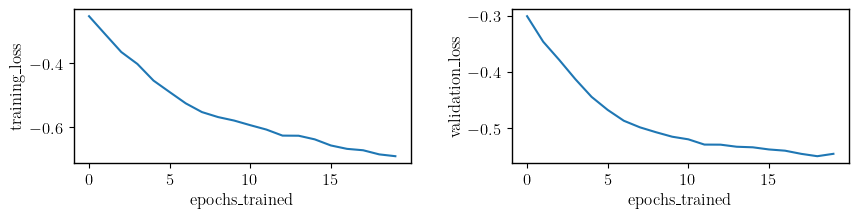

In [16]:
sbi_C9.train(data[:,:,0], parameters) # pour l'instant une dimension de point (il faut fair encoder)
Ploter_Validator.plot_loss(sbi_C9.neural_network)

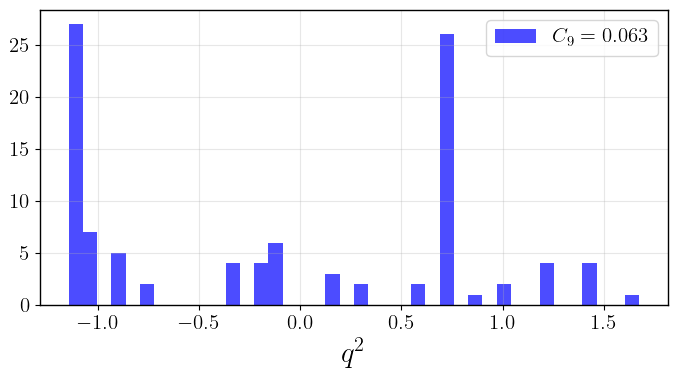

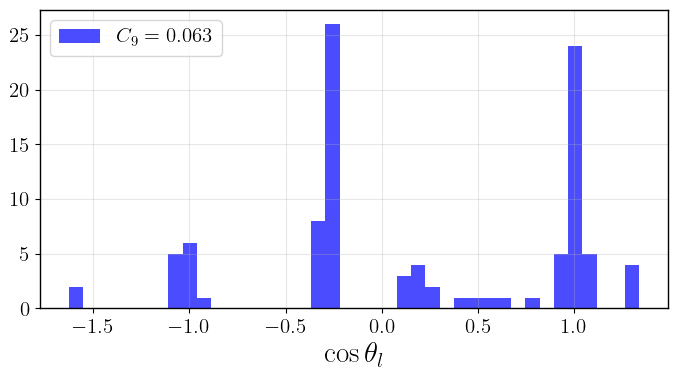

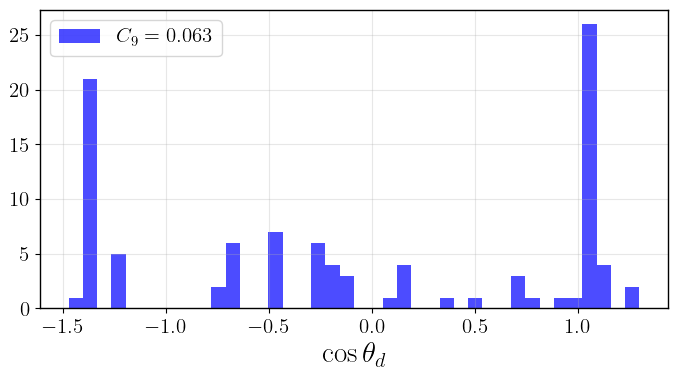

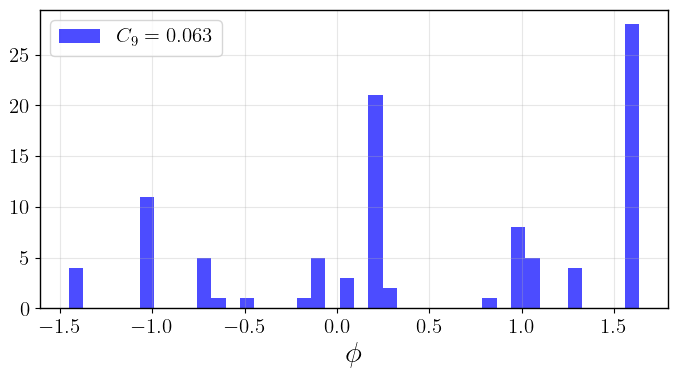

In [17]:
Ploter_Validator.plot_a_sample(sbi_C9,data[0], parameters[0])

In [ ]:
true_parameter, observed_sample = sbi_C9.get_random_true_parameter(n_points)
n_sampled_parameters = 1000
sampled_parameters = sbi_C9.draw_parameters_from_predicted_posterior(observed_sample[:,0], n_sampled_parameters)
Ploter_Validator.plot_a_posterior(sbi_C9, sampled_parameters)

Hello 3.913973808288574


Pre-runs:   0%|          | 0/1 [00:00<?, ?it/s]

Prerun 0 out of 1
Prerun 0: acceptance rate is  47%
Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Main run: acceptance rate is 121%


  0%|          | 0/1000 [00:00<?, ?it/s]

                    accepted. It may take a long time to collect the remaining
                    1000 samples. Consider interrupting (Ctrl-C) and switching to
                    `build_posterior(..., sample_with='mcmc')`.


In [ ]:
Ploter_Validator.plot_similar_data(sbi_C9, observed_sample, n_sampled_parameters)